In [1]:
!git clone https://github.com/amitkaps/recommendation.git

Cloning into 'recommendation'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 2204 (delta 79), reused 125 (delta 30), pack-reused 2006
Receiving objects: 100% (2204/2204), 63.41 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (249/249), done.


## Framing

- Items are stories posted on HN
- Users are users commenting or posting stories
- Signal are comments on the stories by the user signalling interest

## Data 

Lets see the sources for getting historical information posted on HackerNews

- **HackerNews API** - YCombinator provides an official hackernew api through Firebase. This is a near real-time database and provides both an *items* (stories and comments) as well as an *users* api.  It is available at https://github.com/HackerNews/API

- **BigQuery** : Google Big Query has a daily updated HackerNews public dataset available (from 2006 to date). It only has *items* information. It is available at https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.full

### Items (Stories) 

The schema for the Big Query table is

| Field       | Type      | Description                           |
|:------------|----------:|:--------------------------------------|
| by          | STRING    | The username of the item's author.    |
| score       | INTEGER   | Story score                           |
| time        | INTEGER   | Unix time                             |
| timestamp   | TIMESTAMP | Timestamp for the unix time           |
| title       | STRING    | Story title                           |
| type        | STRING    | Type of details (comment, story, ...) |
| url         | STRING    | Story url                             |
| text        | STRING    | Story or comment text                 |
| parent      | INTEGER   | Parent comment ID                     |
| deleted     | BOOLEAN   | Is deleted?                           |
| dead        | BOOLEAN   | Is dead?                              |
| descendants | INTEGER   | Number of story or poll descendants   |
| id          | INTEGER   | The item's unique id.                 |
| ranking     | INTEGER   | Comment ranking                       |


- Get all the stories posted on HackerNews in **2017 (till date)**. 
- To ensure a relevant set, we will limit the stories which have atleast have **score of 5 points or more** on them. 

```SQL
#standardSQL
SELECT * 
FROM `bigquery-public-data.hacker_news.full`
WHERE type="story" AND score > 4 AND EXTRACT(YEAR FROM timestamp)=2017
```

In [ ]:
import pandas as pd
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

project_id = 'silken-psyxxx-xxxxxx'

In [10]:
query = """SELECT * 
FROM `bigquery-public-data.hacker_news.full`
WHERE type="story" AND score > 4 AND EXTRACT(YEAR FROM timestamp)=2017""" 

df = pd.read_gbq(query, project_id=project_id, dialect='standard')
df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,Ask HN: How Apple encrypt iCloud photos?,None,"Here, at HN, we all care about privacy.<p>Appl...",None,ex3ndr,5,1511298567,2017-11-21 21:09:27+00:00,story,15751571,None,0.0,None,None
1,Ask HN: Best consumer EEG hardware and software?,None,What&#x27;s the best consumer level EEG hardwa...,None,hanniabu,5,1486834334,2017-02-11 17:32:14+00:00,story,13623602,None,3.0,None,None
2,Ask HN: Devs: How did you go from writing just...,None,Short background: I’ve been a developer for 3 ...,None,krptos,5,1483362724,2017-01-02 13:12:04+00:00,story,13300955,None,4.0,None,None
3,Ask HN: Are exceptional programmers highly opi...,None,It seems to me that many respected programmers...,None,afco,5,1486402505,2017-02-06 17:35:05+00:00,story,13581818,None,3.0,None,None
4,Ask HN: Does your organization use SecDevOps?,None,What approach do you take for data and infrast...,None,mngutterman,5,1487086924,2017-02-14 15:42:04+00:00,story,13644257,None,5.0,None,None


In [5]:
# df.to_csv('HackerNews_stories.csv', index=False)
# !cp HackerNews_stories.csv /content/drive/MyDrive/TempData

In [13]:
query = """SELECT  *
FROM `bigquery-public-data.hacker_news.full`
WHERE type="comment" AND parent IN 
 (SELECT id
  FROM `bigquery-public-data.hacker_news.full`
  WHERE type="story" AND score > 4 AND EXTRACT(YEAR FROM timestamp)=2017)""" 

df = pd.read_gbq(query, project_id=project_id, dialect='standard')
df.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,I&#x27;m not sure I would give myself a CTO ti...,None,richardknop,None,1501843819,2017-08-04 10:50:19+00:00,comment,14927732,14923930,None,None,None
1,None,None,It&#x27;s funny how more and more macos design...,None,jbverschoor,None,1501843976,2017-08-04 10:52:56+00:00,comment,14927739,14925743,None,None,None
2,None,None,And people who have more sex make more money.,None,dizzyo,None,1490995225,2017-03-31 21:20:25+00:00,comment,14008380,14007029,None,None,None
3,None,None,"And I have evidence that robots create jobs, a...",None,dbcurtis,None,1490995247,2017-03-31 21:20:47+00:00,comment,14008382,14006390,None,None,None
4,None,None,I want easy upgrades. The last time I upgraded...,None,WheelsAtLarge,None,1490995255,2017-03-31 21:20:55+00:00,comment,14008385,14002821,None,None,None


In [16]:
# df = df[['by','parent']]
# df.to_csv('HackerNews_comments.csv', index=False)
# !cp HackerNews_comments.csv /content/drive/MyDrive/TempData

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [7]:
stories_all = pd.read_csv("HackerNews_stories.csv")
stories_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59600 entries, 0 to 59599
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        59600 non-null  object 
 1   url          54576 non-null  object 
 2   text         4349 non-null   object 
 3   dead         1998 non-null   object 
 4   by           59600 non-null  object 
 5   score        59600 non-null  int64  
 6   time         59600 non-null  int64  
 7   timestamp    59600 non-null  object 
 8   type         59600 non-null  object 
 9   id           59600 non-null  int64  
 10  parent       0 non-null      float64
 11  descendants  57602 non-null  float64
 12  ranking      0 non-null      float64
 13  deleted      0 non-null      float64
dtypes: float64(4), int64(3), object(7)
memory usage: 6.4+ MB


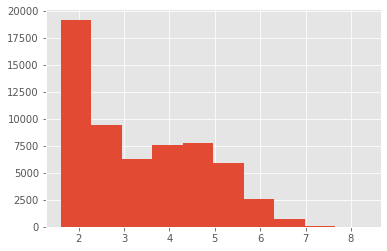

In [8]:
np.log(stories_all.score).hist()

In [9]:
# Select Most Popular Stories
stories = stories_all[stories_all.score > 500].copy()
stories.sort_values('score', ascending=False)
stories = stories[['id', 'title' , 'score', 'by']]
stories.columns = ['story', 'title',  'score', 'user']
stories.head()

,story,title,score,user
80,13840282,Ask HN: How do you set prices?,584,fnbr
81,14238005,Ask HN: Who is hiring? (May 2017),589,whoishiring
90,14437921,Ask HN: What are some examples of successful s...,685,1ba9115454
474,14766889,Alibaba Cloud,520,paulmach
773,13382263,Georgia Tech Offers Online Master of Science i...,533,dgritsko


In [17]:
comments_all = pd.read_csv("HackerNews_comments.csv")
comments_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472241 entries, 0 to 472240
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   by      456958 non-null  object
 1   parent  472241 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.2+ MB


In [18]:
comments_all.dropna(inplace = True)
comments_all.columns = ['user', 'story']
comments_all['comment'] = 1
comments_all.head()

,user,story,comment
0,richardknop,14923930,1
1,jbverschoor,14925743,1
2,dizzyo,14007029,1
3,dbcurtis,14006390,1
4,WheelsAtLarge,14002821,1


In [25]:
# story_user_comment = comments_all[comments_all['story'].isin(stories.story)]
# story_user_comment.to_csv('HackerNews_Story_UserComments.csv', index=False)
# !cp HackerNews_Story_UserComments.csv /content/drive/MyDrive/TempData

We need to get the details for all the users that have made comments in our list of stories.

Also, we are interested in their details

- How long have they been on the HN platform? (Created)
- How active they are? (# of comments)?
- How good they are to the HN community (karma)?

In [23]:
import requests

users_list = story_user_comment.user.unique()
print(len(users_list))

# Lets get the first user
user = users_list[0]

# Lets get karma, created date and number of comments
r = requests.get("https://hacker-news.firebaseio.com/v0/user/" + user + ".json")
created = r.json()['created']
karma = r.json()['karma']
submitted = len(r.json()['submitted'])
print([user, created, karma, submitted])

23804
['WheelsAtLarge', 1381812966, 3065, 1399]


In [24]:
# Lets create a function to get the same detail from a list of users

def getUserData(users): 
    '''
    Function to get user details from the HackerNews API
    And store in a dataframe
    '''
    column_names = ['user', 'created', 'karma', 'submitted']
    userDf = pd.DataFrame(columns = column_names)

    for index, user in enumerate(users):
        
        #Get User Details
        try: 
            r = requests.get("https://hacker-news.firebaseio.com/v0/user/"+ user +".json")
            userDetails = r.json()            
        
            # Get details
            created = userDetails['created']
            karma = userDetails['karma']
            submitted = len(userDetails['submitted'])

            #Store in the DataFrame
            userDf.loc[index] = [user, created, karma, submitted] 
            #print([user, created, karma, submitted] )
            
            #Print every hundred records to check progress
            if index%100 == 0:
                print(index)
            
        except:
            continue
     
    return userDf

def downloadUserAll(users_list): 
    total = len(users_list)
    turn = int(total/20)
    start = 0
    end = turn
    
    for i in range(1, 21):
        user_df_step = getUserData(users_list[start:end])
        user_df_step.to_csv("data/users" + str(i) + ".csv", index=False)
        print(start, end, "data/users" + str(i) + ".csv")
        start = end
        end = min(end + turn, total)

In [ ]:
# Lets dowload all the user data 
# Note: This takes about an hour to run
downloadUserAll(users_list)

In [ ]:
# Lets create the users database
column_names = ['user', 'created', 'karma', 'submitted']
users = pd.DataFrame(columns = column_names)

for i in range(1,21):
    print(i)
    user_df_step = pd.read_csv("/content/recommendation/HackerNews/data/users" + str(i) + ".csv")
    users = pd.concat([users, user_df_step], ignore_index=True)

In [ ]:
# users.to_csv('HackerNews_users.csv', index=False)
# !cp HackerNews_users.csv /content/drive/MyDrive/TempData

---

In [ ]:
! pip install mlxtend

In [30]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from mlxtend.preprocessing import OnehotTransactions

In [28]:
def OHE_Matrix( df ) :

    g2 = df.groupby(["user"], as_index = False)
    
    Itemset = []
    user = []
    for item in list(g2.groups.keys()) :
        Itemset.append( list(g2.get_group(item)["story"]))
        user.append(item) 
        
    oht = OnehotTransactions()
    u = oht.fit(Itemset).transform(Itemset)
    
    Matrix = pd.DataFrame(u, columns = oht.columns_)
    Matrix["user"] = user
    Matrix = Matrix.set_index("user")
    
    return Matrix

In [32]:
story_user_comment

,user,story,comment
4,WheelsAtLarge,14002821,1
26,thecompilr,15974603,1
40,uncensored,14073223,1
70,jameshart,13400291,1
72,GlennS,15786802,1
...,...,...,...
471877,giancarlostoro,15237896,1
471879,duke360,14643712,1
471880,trevos,14643712,1
471882,throwaway201,14643712,1


In [33]:
matrix1 = OHE_Matrix(story_user_comment)
matrix1.head()

/usr/local/lib/python3.7/dist-packages/mlxtend/preprocessing/onehot.py:66: DeprecationWarning: OnehotTransactions has been deprecated and will be removed in future. Please use TransactionEncoder instead.
  warnings.warn(msg, DeprecationWarning)


,13296502,13297792,13301832,13309025,13309610,13312629,13317902,13319904,13326535,13326792,13329525,13330611,13338592,13347852,13354329,13356318,13361019,13364583,13365430,13369510,13370310,13372985,13375337,13375543,13382263,13382963,13385873,13389935,13390511,13392620,13392885,13394900,13397145,13399095,13399974,13400291,13400350,13404758,13406119,13406638,...,15913250,15916121,15917829,15919115,15920618,15921692,15924093,15924794,15927132,15930916,15931730,15937448,15940144,15940318,15941428,15946095,15946425,15947540,15949144,15950599,15951825,15956811,15960747,15965653,15969511,15974603,15980653,15986753,15990559,15994410,16000550,16001407,16009459,16015539,16022916,16024624,16025112,16030838,16035402,16036121
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0003,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
01000001,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
010001001010,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
01096232042,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
010a,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [34]:
n_users = story_user_comment.user.unique().shape[0]
n_stories = story_user_comment.story.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of stories: {}'.format(n_stories))
print('Sparsity: {:4.3f}%'.format(float(story_user_comment.shape[0]) / float(n_users*n_stories)))

Number of users: 23804
Number of stories: 1008
Sparsity: 0.002%


In [37]:
def Sparse_Matrix(df):
    
    # Create mappings
    user_to_index = {}
    index_to_user = {}
    for (index, user) in enumerate(df.user.unique().tolist()):
        user_to_index[user] = index
        index_to_user[index] = user

    story_to_index = {}
    index_to_story = {}
    for (index, story) in enumerate(df.story.unique().tolist()):
        story_to_index[story] = index
        index_to_story[index] = story
        
    # Create a map id function
    def map_ids(row, mapper):
        return mapper[row]
    
    # Apply the map id function 
    I = df.user.apply(map_ids, args=[user_to_index]).to_numpy()
    J = df.story.apply(map_ids, args=[story_to_index]).to_numpy()
    V = np.ones(I.shape[0])
    
    # Create the Matrix
    story_user = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
    story_user_matrix = story_user.tocsr()
    
    return story_user_matrix

In [38]:
matrix2 = Sparse_Matrix(story_user_comment)
matrix2

<23804x1008 sparse matrix of type '<class 'numpy.float64'>'
	with 53041 stored elements in Compressed Sparse Row format>

---

In [49]:
! pip install spacy
! python -m spacy download en

import spacy
import warnings

nlp = spacy.load('en')
warnings.filterwarnings("ignore")

In [46]:
stories = pd.read_csv('HackerNews_stories.csv')
stories[:2]

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,Ask HN: How Apple encrypt iCloud photos?,NaN,"Here, at HN, we all care about privacy.<p>Appl...",NaN,ex3ndr,5,1511298567,2017-11-21 21:09:27+00:00,story,15751571,NaN,0.0,NaN,NaN
1,Ask HN: Best consumer EEG hardware and software?,NaN,What&#x27;s the best consumer level EEG hardwa...,NaN,hanniabu,5,1486834334,2017-02-11 17:32:14+00:00,story,13623602,NaN,3.0,NaN,NaN


In [50]:
title0 = nlp(stories.title[0])
title1 = nlp(stories.title[1])

print(title0, title1)
print(len(title0.vector), len(title1.vector))
print(title0.similarity(title1))

Ask HN: How Apple encrypt iCloud photos? Ask HN: Best consumer EEG hardware and software?
96 96
0.7358155169371403


In [51]:
story_similarity = []

# The below code is time consuming - and so, we will run it only for the first 100 titles
for story_row in stories.title[:100]:
    for story_column in stories.title[:100]:
        story_sim = nlp(story_row).similarity(nlp(story_column))
        story_similarity.append([story_row, story_column, story_sim])

story_similarity = pd.DataFrame(story_similarity,
                               columns = ["story1", "story2", "similarity"] )

story_similarity.head()

,story1,story2,similarity
0,Ask HN: How Apple encrypt iCloud photos?,Ask HN: How Apple encrypt iCloud photos?,1.000000
1,Ask HN: How Apple encrypt iCloud photos?,Ask HN: Best consumer EEG hardware and software?,0.735816
2,Ask HN: How Apple encrypt iCloud photos?,Ask HN: Devs: How did you go from writing just...,0.649074
3,Ask HN: How Apple encrypt iCloud photos?,Ask HN: Are exceptional programmers highly opi...,0.660919
4,Ask HN: How Apple encrypt iCloud photos?,Ask HN: Does your organization use SecDevOps?,0.626567


In [55]:
similarity_matrix = pd.pivot(story_similarity, 
                             index='story1',
                             columns='story2',
                             values='similarity')

similarity_matrix.head()

story2,AWS IAM Down,Are the new TLDs really black holes for SEO?,Ask HN: A story about a research adviser who automated himself,Ask HN: An API to store/retrieve JSON?,Ask HN: Any great product onboarding experiences you've had lately?,Ask HN: Are all developers sith by nature?,Ask HN: Are exceptional programmers highly opinionated?,Ask HN: Are large corporations with fraudulent IT managers the norm?,Ask HN: Are there any open-source alternatives to AWS Lambda,Ask HN: Best consumer EEG hardware and software?,Ask HN: Best noise cancelling headphones for developers,"Ask HN: Best tech for a web site 2018? (PHP, Rails, Django, Node, Go, etc.)?",Ask HN: Can Cryptocurrency Beat Credit Card in Consumer Micro Payment Market?,"Ask HN: Devs: How did you go from writing just code, to writing code + tests?",Ask HN: Do you reveal all of your code to contractors?,Ask HN: Do you skip phone interviews for Google/FB/Tier-1 company engineers?,Ask HN: Do you use dedicated GitHub/NPM/etc. accounts for work?,Ask HN: Does anyone use online standup tools?,Ask HN: Does your organization use SecDevOps?,Ask HN: Favorite blogs?,Ask HN: Freelancer? Seeking freelancer? (May 2017),Ask HN: Google Doc email virus?,Ask HN: Hacker News users reading habits,Ask HN: How Apple encrypt iCloud photos?,Ask HN: How best to report phishing emails to a domain holder?,Ask HN: How do I compile a list of censored websites in my country,Ask HN: How do you gain weight?,Ask HN: How do you set prices?,Ask HN: How do your team write documentation?,Ask HN: How has Satoshi Nakamoto been so good at opsec all this time?,Ask HN: How long before new developer starts contributing code in your company?,Ask HN: How often do you experience self-control issues?,Ask HN: How should I study algorithms and datastructures?,Ask HN: How to get into the space industry as citizen from 3rd world?,Ask HN: How to introduce someone to programming concepts during 12-hour drive?,Ask HN: How to learn new things better?,Ask HN: How to scale a startup after initial traction (books/resources/etc)?,Ask HN: How to succeed in tech as an introvert?,Ask HN: How you wake up?,Ask HN: Introductory CS resources for dyslexic teenager?,...,Ask HN: What was impossible earlier that is easy in the BTC and ETH blockchains?,Ask HN: What's the best indoor air quality monitor?,Ask HN: What's the most interesting URL you've seen?,Ask HN: What's your biggest struggle with Microservices?,Ask HN: Where is the days most interesting tech posts?,Ask HN: Where is there so much cryptocurrency skepticism on HN?,Ask HN: Where should I keep my recovery codes (Google account for exemple)?,Ask HN: Where to incorporate a European startup?,Ask HN: Who is hiring? (May 2017),Ask HN: Who wants to be hired? (May 2017),Ask HN: Who'se running a nonprofit here?,Ask HN: Why HN does not have categories for news,Ask HN: Why are flash memory prices going down so much faster than RAM?,Ask HN: Why is Google Cloud not allowed for individuals in Europe?,Ask HN: Why is law stuff seemingly against normal people?,Ask HN: Why nobody cares about good engineering rather than how to reduce costs?,Ask HN: Why wouldn't FB “steal” my startup idea?,Ask HN: Will JavaScript take over the world of programming?,Ask HN: Would you switch to Win 10 from OS X on a MacBook Pro?,Blum: “The proof is wrong. I shall elaborate precisely what the mistake is.”,Court OKs child porn prosecution of minors distributing pictures of themselves,"Don't post a GitHub issue unless you have contributed code, or donated $50 cash","Drag and drop editor like Scratch, but for Python – all coded by a 13 year old",GitHub is down,Government/FBI hacked my MacBook Pro,HTML 5P CODE,"I love coding, and I am 40. Can I still become a developer – and is it worth it?",I turned $1.24 into $1000 of UberEATS credit,Launch HN: Muzmatch (YC S17) – A place where 400M single Muslims can meet,"Launching a new App Store today, proceeds going to ACLU","Predictive Analysis for Crypto: The spreadsheet that got me my fi

---

In [ ]:
# !pip install pyfpgrowth

In [59]:
import pyfpgrowth
import random

user_stories = pd.read_csv("HackerNews_Story_UserComments.csv")
user_stories_sorted = user_stories.sort_values("user")
unique_users = pd.unique(user_stories_sorted.user)

basket = []

for user in unique_users[:100]:
    user_data = user_stories_sorted[user_stories_sorted.user == user].copy()
    user_stories = pd.unique(user_data.story)
    user_stories = [data.tolist() for data in user_stories]
    basket.append(user_stories)

len(basket)

100

In [63]:
hn_fptree = pyfpgrowth.pyfpgrowth.FPTree(basket, 0.1, 0.1, 0.1)
random.sample(hn_fptree.frequent.items(), 10)

[(15066729, 1),
 (15601729, 1),
 (14087381, 1),
 (14446261, 1),
 (15228712, 1),
 (15254952, 1),
 (15956811, 1),
 (14997799, 1),
 (15234207, 2),
 (13301832, 2)]

In [79]:
patterns = pyfpgrowth.find_frequent_patterns(basket, 2)
print(len(patterns))
random.sample(patterns.items(), 10)

20


[((14023198,), 2),
 ((13301832,), 2),
 ((15037960,), 3),
 ((15937448,), 2),
 ((13601451,), 2),
 ((13338592,), 2),
 ((15089476,), 2),
 ((15316175,), 3),
 ((14039135,), 2),
 ((14108797,), 2)]

In [80]:
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)
rules

{}

---

In [86]:
! pip install implicit

     |████████████████████████████████| 1.1MB 8.3MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406364 sha256=d8394d0c1f80f33c3468d286f8b2e874e082f1f58455befd69adc4a05dbdfc4b
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [87]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import implicit

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
np.set_printoptions(precision=2)

In [82]:
"""
@INPUT:
    R     : a matrix to be factorized, dimension N x M
    P     : an initial matrix of dimension N x K
    Q     : an initial matrix of dimension M x K
    K     : the number of latent features
    steps : the maximum number of steps to perform the optimisation
    alpha : the learning rate
    beta  : the regularization parameter
@OUTPUT:
    the final matrices P and Q
"""

def als_matrix_factorization(R, K=2, steps=5000, alpha=0.0002, beta=0.02):
    N = len(R)
    M = len(R[0])
    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)
    Q = Q.T
    
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
    return P, Q.T

In [83]:
R = np.array([[1, 0, 1, 0, 0], 
              [0, 1, 0, 0, 1], 
              [1, 0, 0, 1, 0], 
              [0, 0, 1, 0, 0]])

# Run ALS
nP, nQ = als_matrix_factorization(R, K=2)

nP.dot(nQ.T)

array([[1.02, 0.97, 0.99, 1.12, 1.01],
       [1.01, 0.98, 0.99, 1.1 , 0.98],
       [0.93, 0.71, 0.77, 1.03, 1.01],
       [0.95, 0.99, 0.97, 1.03, 0.89]])

In [84]:
nQ

array([[0.72, 0.66],
       [0.98, 0.29],
       [0.9 , 0.4 ],
       [0.77, 0.75],
       [0.56, 0.83]])

In [85]:
nP

array([[0.8 , 0.68],
       [0.82, 0.62],
       [0.45, 0.92],
       [0.86, 0.49]])

In [91]:
def Sparse_Matrix(df):
    
    # Create mappings
    user_to_index = {}
    index_to_user = {}
    
    for (index, user) in enumerate(df.user.unique().tolist()):
        user_to_index[user] = index
        index_to_user[index] = user

    story_to_index = {}
    index_to_story = {}
    
    for (index, story) in enumerate(df.story.unique().tolist()):
        story_to_index[story] = index
        index_to_story[index] = story
        
    # Create a map id function
    def map_ids(row, mapper):
        return mapper[row]
    
    # Apply the map id function 
    I = df.user.apply(map_ids, args=[user_to_index]).to_numpy()
    J = df.story.apply(map_ids, args=[story_to_index]).to_numpy()
    V = np.ones(I.shape[0])
    
    # Create the Matrix    
    return I, J, V

In [92]:
user_stories = pd.read_csv("HackerNews_Story_UserComments.csv")
I, J, V = Sparse_Matrix(user_stories)
story_user_matrix = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
story_user_matrix = story_user_matrix.tocsr()
story_user_matrix

<23804x1008 sparse matrix of type '<class 'numpy.float64'>'
	with 53041 stored elements in Compressed Sparse Row format>

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=32)
model.fit(story_user_matrix)
user_items = story_user_matrix.T.tocsr()

In [ ]:
recommendations = model.recommend(I[2000], user_items) #200th user
recommendations

In [ ]:
related = model.similar_items(J[200])
related

---